<a href="https://colab.research.google.com/github/liudmylasovetovs/ML/blob/main/%D0%94%D0%971_%D0%A1%D0%BE%D0%B2%D1%94%D1%82%D0%BE%D0%B2%D1%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Імпорт
import sys, numpy as np, pandas as pd
import sklearn
import scipy
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

In [ ]:
# 2. Завантаження даних
cal = fetch_california_housing(as_frame=True)
df = cal.frame.copy()
df.head(3), df.shape, df.columns.tolist()

(   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
 0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
 1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
 2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
 
    Longitude  MedHouseVal  
 0    -122.23        4.526  
 1    -122.22        3.585  
 2    -122.24        3.521  ,
 (20640, 9),
 ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude',
  'MedHouseVal'])

In [ ]:
# 3. Копії датасету
df_base = df.copy()
df_upd = df.copy()

In [ ]:
# 4A. Базовий пайплайн
TARGET = 'MedHouseVal'
FEATURES = [c for c in df_base.columns if c != TARGET]

X = df_base[FEATURES].values
y = df_base[TARGET].values

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

scaler_b = StandardScaler()
X_train_b_scaled = scaler_b.fit_transform(X_train_b)
X_test_b_scaled  = scaler_b.transform(X_test_b)

model_b = LinearRegression()
model_b.fit(X_train_b_scaled, y_train_b)

r2_train_b = model_b.score(X_train_b_scaled, y_train_b)
y_pred_b = model_b.predict(X_test_b_scaled)
mae_b = mean_absolute_error(y_test_b, y_pred_b)
mape_b = mean_absolute_percentage_error(y_test_b, y_pred_b)

print(f"[BASE] R2 (train): {r2_train_b:.4f} | MAE (test): {mae_b:.4f} | MAPE (test): {mape_b:.4f}")

[BASE] R2 (train): 0.6126 | MAE (test): 0.5332 | MAPE (test): 0.3195


In [ ]:
# 4B-1. Очистка від викидів у df_upd
cols_outlier = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
z = df_upd[cols_outlier].apply(zscore, nan_policy='omit')
mask_any_outlier = (np.abs(z) > 3).any(axis=1)

print("К-сть рядків ДО чистки:", df_upd.shape[0])
print("Аномальних рядків:", mask_any_outlier.sum())

df_upd_clean = df_upd.loc[~mask_any_outlier].reset_index(drop=True)
print("К-сть рядків ПІСЛЯ чистки:", df_upd_clean.shape[0])

К-сть рядків ДО чистки: 20640
Аномальних рядків: 505
К-сть рядків ПІСЛЯ чистки: 20135


In [ ]:
# 4B-2. Видалення однієї високо корельованої ознаки
TARGET = 'MedHouseVal'
feat_cols = [c for c in df_upd_clean.columns if c != TARGET]

corr_mat = df_upd_clean[feat_cols].corr(method='pearson').abs()

high_pairs = []
th = 0.85
for i, c1 in enumerate(feat_cols):
    for c2 in feat_cols[i+1:]:
        r = corr_mat.loc[c1, c2]
        if r > th:
            high_pairs.append((c1, c2, r))

print("Пари з високою кореляцією (> 0.85):", high_pairs)

corr_to_target = df_upd_clean[feat_cols + [TARGET]].corr()[TARGET].abs().drop(TARGET)

drop_feature = None
if high_pairs:
    c1, c2, r = high_pairs[0]
    if corr_to_target[c1] >= corr_to_target[c2]:
        drop_feature = c2
    else:
        drop_feature = c1

if drop_feature:
    print(f"Видаляємо ознаку через високу міжфічерну кореляцію: {drop_feature}")
    feat_cols_upd = [c for c in feat_cols if c != drop_feature]
else:
    print("Високо корельованих пар за порогом не виявлено — ознаки залишаємо всі.")
    feat_cols_upd = feat_cols

feat_cols_upd

Пари з високою кореляцією (> 0.85): [('Latitude', 'Longitude', np.float64(0.9278710501098077))]
Видаляємо ознаку через високу міжфічерну кореляцію: Longitude


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude']

In [ ]:
# 5. Train/Test split для оновленого датасету
X = df_upd_clean[feat_cols_upd].values
y = df_upd_clean[TARGET].values

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train_u.shape, X_test_u.shape

((16108, 7), (4027, 7))

In [ ]:
# 6. Масштабування + лінійна регресія
scaler_u = StandardScaler()
X_train_u_scaled = scaler_u.fit_transform(X_train_u)
X_test_u_scaled  = scaler_u.transform(X_test_u)

model_u = LinearRegression()
model_u.fit(X_train_u_scaled, y_train_u)

LinearRegression()

In [ ]:
# 7. Метрики оновленої моделі
r2_train_u = model_u.score(X_train_u_scaled, y_train_u)
y_pred_u = model_u.predict(X_test_u_scaled)
mae_u = mean_absolute_error(y_test_u, y_pred_u)
mape_u = mean_absolute_percentage_error(y_test_u, y_pred_u)

print(f"[UPDATED] R2 (train): {r2_train_u:.4f} | MAE (test): {mae_u:.4f} | MAPE (test): {mape_u:.4f}")

[UPDATED] R2 (train): 0.5883 | MAE (test): 0.5437 | MAPE (test): 0.3254


[BASE: Distribution of True vs Predicted] KS statistic: 0.1286 | p-value: 0.0000
[UPDATED: Distribution of True vs Predicted] KS statistic: 0.1274 | p-value: 0.0000


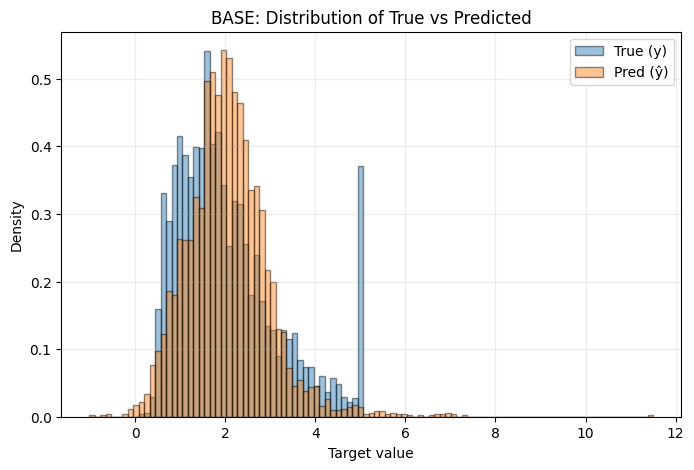

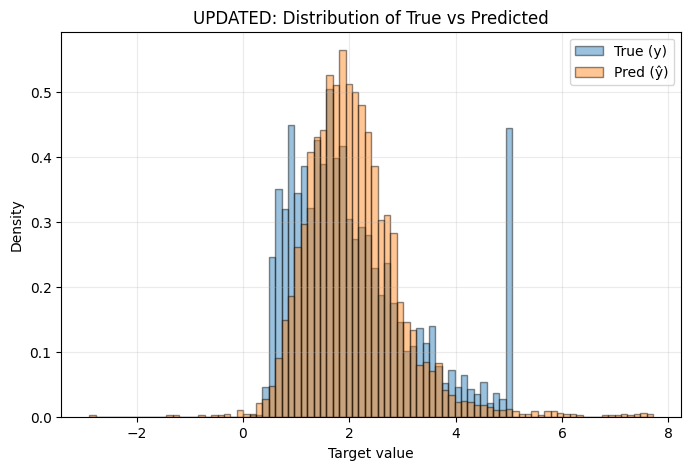

In [ ]:
def plot_true_vs_pred_distributions(y_true, y_pred, title):
    fig, ax = plt.subplots(figsize=(8,5))

    bins = np.histogram_bin_edges(np.concatenate([y_true, y_pred]), bins='auto')

    ax.hist(y_true, bins=bins, alpha=0.45, density=True, label='True (y)', edgecolor='black')
    ax.hist(y_pred, bins=bins, alpha=0.45, density=True, label='Pred (ŷ)', edgecolor='black')

    ax.set_title(title)
    ax.set_xlabel('Target value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.25)

    ks_stat, ks_p = ks_2samp(y_true, y_pred)
    print(f"[{title}] KS statistic: {ks_stat:.4f} | p-value: {ks_p:.4f}")

plot_true_vs_pred_distributions(y_test_b, y_pred_b, "BASE: Distribution of True vs Predicted")

plot_true_vs_pred_distributions(y_test_u, y_pred_u, "UPDATED: Distribution of True vs Predicted")

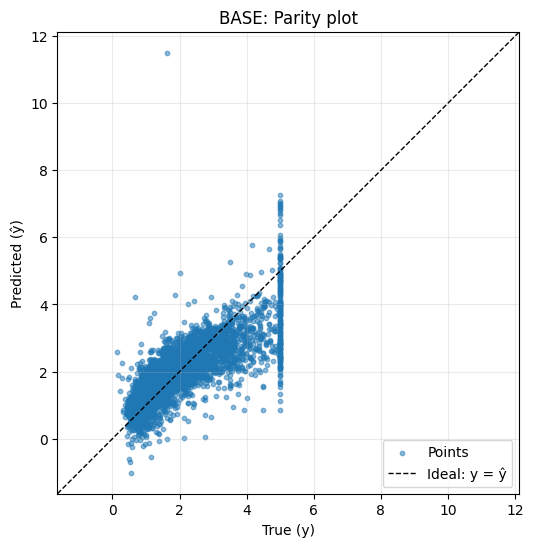

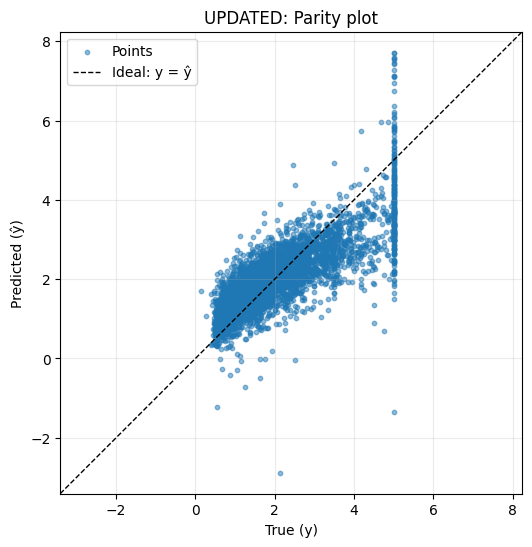

In [ ]:
def plot_parity(y_true, y_pred, title):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(y_true, y_pred, s=10, alpha=0.5, label='Points')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k--', linewidth=1, label='Ideal: y = ŷ')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('True (y)')
    ax.set_ylabel('Predicted (ŷ)')
    ax.grid(alpha=0.25)
    ax.legend()

plot_parity(y_test_b, y_pred_b, "BASE: Parity plot")
plot_parity(y_test_u, y_pred_u, "UPDATED: Parity plot")

[BASE: Residuals distribution] mean(res): 0.0035 | std(res): 0.7456
[UPDATED: Residuals distribution] mean(res): 0.0137 | std(res): 0.7391


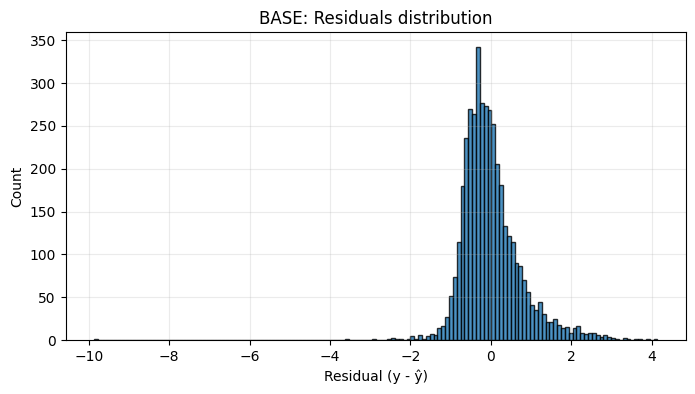

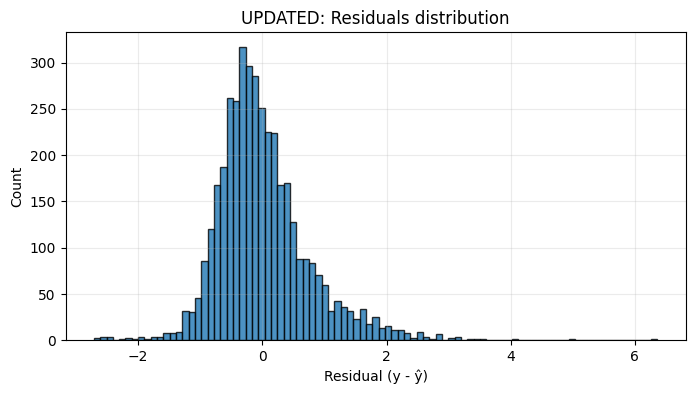

In [ ]:
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred

    fig, ax = plt.subplots(figsize=(8,4))
    bins = np.histogram_bin_edges(residuals, bins='auto')
    ax.hist(residuals, bins=bins, alpha=0.8, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel('Residual (y - ŷ)')
    ax.set_ylabel('Count')
    ax.grid(alpha=0.25)

    mean_res = residuals.mean()
    std_res = residuals.std()
    print(f"[{title}] mean(res): {mean_res:.4f} | std(res): {std_res:.4f}")

plot_residuals(y_test_b, y_pred_b, "BASE: Residuals distribution")
plot_residuals(y_test_u, y_pred_u, "UPDATED: Residuals distribution")

In [ ]:
# 8. Порівняльна таблиця та відсотки
comp = pd.DataFrame({
    'metric': ['R2_train', 'MAE_test', 'MAPE_test(%)'],
    'BASE':   [r2_train_b, mae_b, mape_b*100],
    'UPDATED':[r2_train_u, mae_u, mape_u*100],
})
comp['DIFF (UPDATED-BASE)'] = comp['UPDATED'] - comp['BASE']
comp

,metric,BASE,UPDATED,DIFF (UPDATED-BASE)
0,R2_train,0.612551,0.588317,-0.024235
1,MAE_test,0.533200,0.543657,0.010457
2,MAPE_test(%),31.952187,32.538981,0.586793
